In [11]:
from etl import ETLPipeline
from graph_manager import GraphManager, GenericPlotter
from metric_engine import MetricEngine
import matplotlib.pyplot as plt
import numpy as np

In [12]:
workspace_name = "proposal_three_pager_workspace"
data_sources = ["RESS-IoT-wrx=6,numSlots=100,alpha=0.125", "DQ-m=9", "MSDQ-m=21,distribution=exponential,alpha=0.3,t=21,k=1", "LoRaWAN-class=A,ack=unconfirmed"]
node_counts = [10, 50, 100, 200, 300, 400, 500, 1000, 2000, 3000, 4000, 5000]

In [13]:
data_source_to_protocol = {
    "DQ-m=9": "DQ",
    "RESS-IoT-wrx=6,numSlots=100,alpha=0.125": "RESS-IoT",
    "MSDQ-m=21,distribution=exponential,alpha=0.3,t=21,k=1": "MSDQ",
    "LoRaWAN-class=A,ack=unconfirmed": "LoRaWAN"
}

ETLPipeline(data_sources, data_source_to_protocol, node_counts, workspace_name).extract().transform().load()

Starting extract phase
Processing data source: RESS-IoT-wrx=6,numSlots=100,alpha=0.125
Data source path: /home/jason/Code/research-paper-analysis/DRAAF_pipeline/data_sources/RESS-IoT-wrx=6,numSlots=100,alpha=0.125/data
Processing data source: DQ-m=9
Data source path: /home/jason/Code/research-paper-analysis/DRAAF_pipeline/data_sources/DQ-m=9/data
Processing data source: MSDQ-m=21,distribution=exponential,alpha=0.3,t=21,k=1
Data source path: /home/jason/Code/research-paper-analysis/DRAAF_pipeline/data_sources/MSDQ-m=21,distribution=exponential,alpha=0.3,t=21,k=1/data
Processing data source: LoRaWAN-class=A,ack=unconfirmed
Data source path: /home/jason/Code/research-paper-analysis/DRAAF_pipeline/data_sources/LoRaWAN-class=A,ack=unconfirmed/data
Starting transform phase
Processing data source: RESS-IoT-wrx=6,numSlots=100,alpha=0.125
Processing data source: DQ-m=9
Processing data source: MSDQ-m=21,distribution=exponential,alpha=0.3,t=21,k=1
Processing data source: LoRaWAN-class=A,ack=uncon

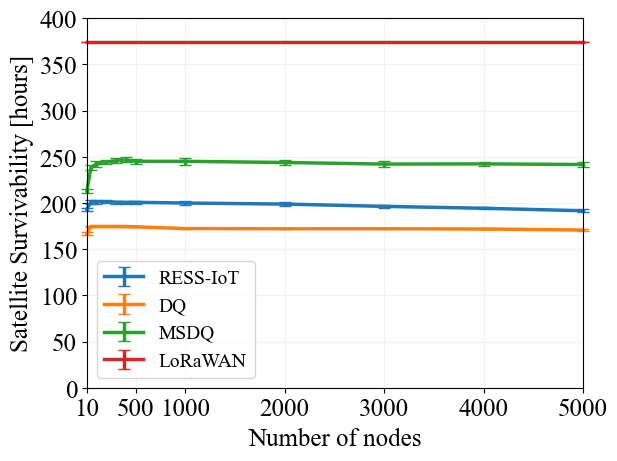

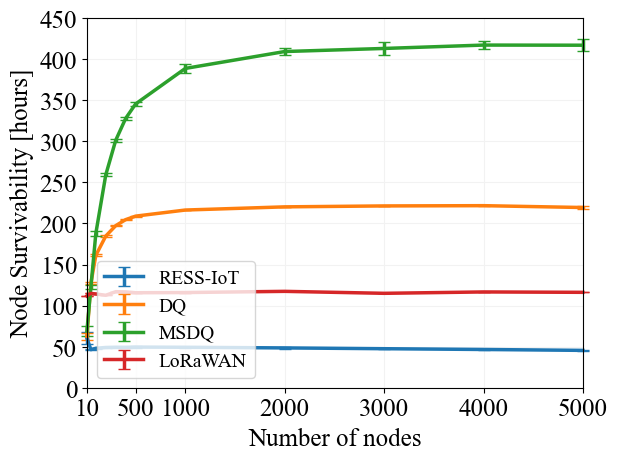

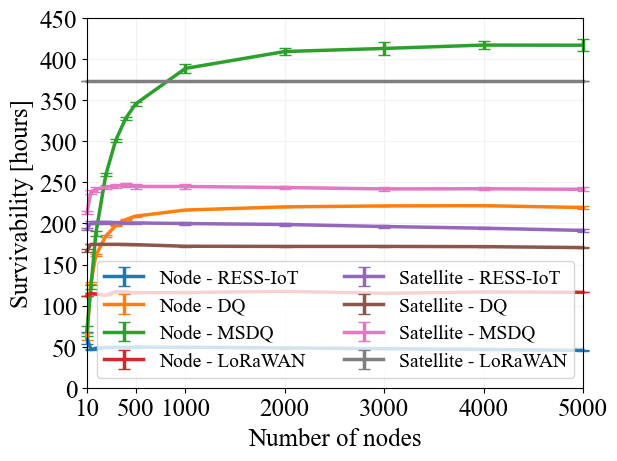

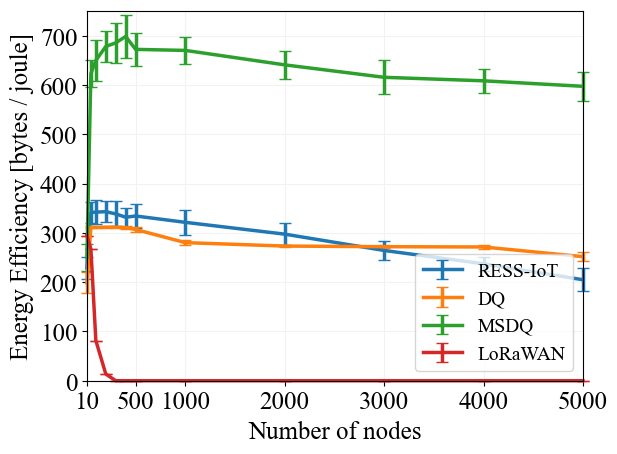

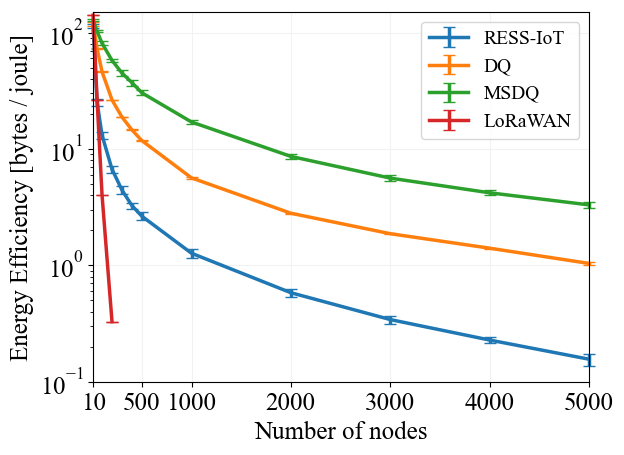

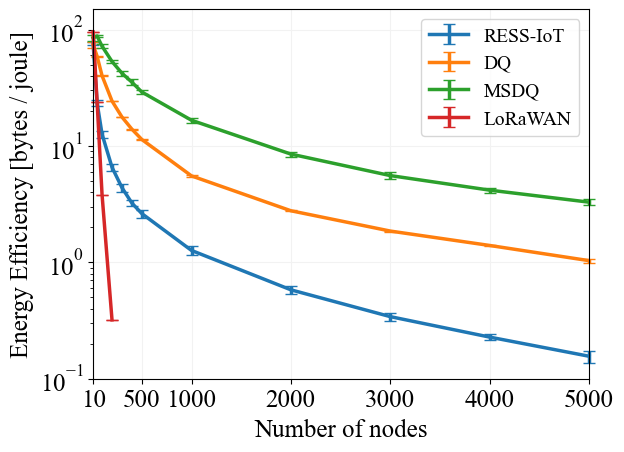

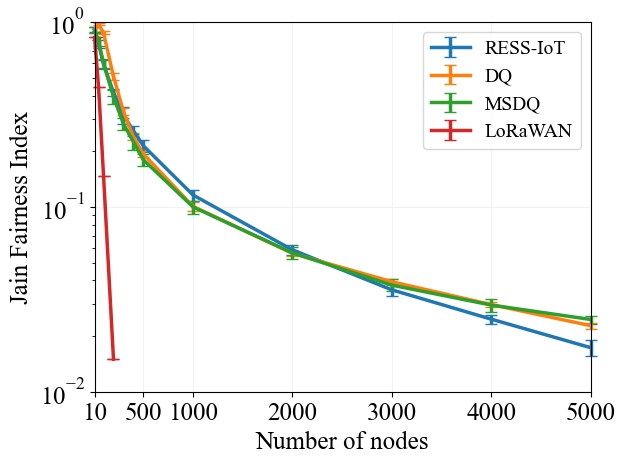

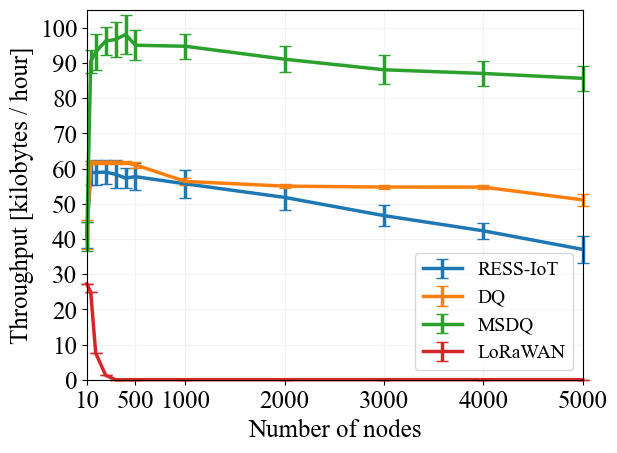

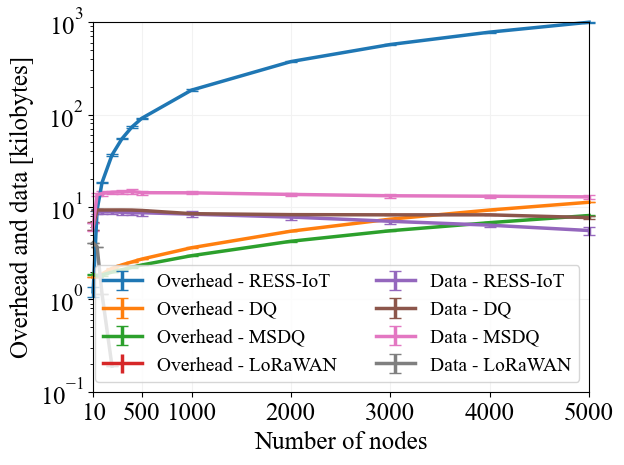

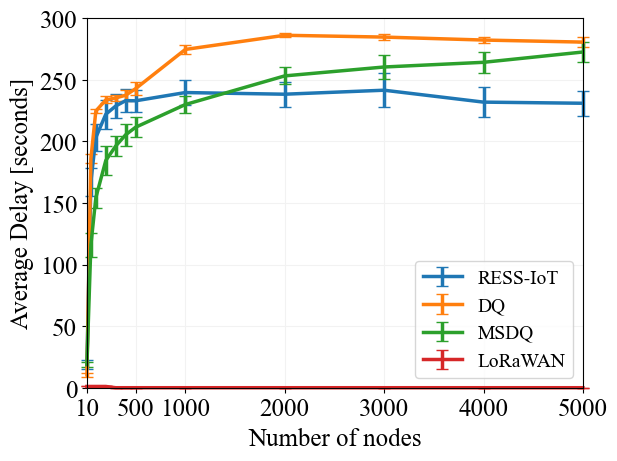

In [14]:
graph_manager = GraphManager(workspace_name)

generic_plotter = GenericPlotter(graph_manager, data_sources, node_counts)

generic_plotter.plot([MetricEngine.SATELLITE_SURVIVABILITY], MetricEngine.SATELLITE_SURVIVABILITY, [0, 400], False)

generic_plotter.plot([MetricEngine.NODE_SURVIVABILITY], MetricEngine.NODE_SURVIVABILITY, [0, 450], False)

generic_plotter.plot([MetricEngine.NODE_SURVIVABILITY, MetricEngine.SATELLITE_SURVIVABILITY], "Survivability [hours]", [0, 450], False, True)

generic_plotter.plot([MetricEngine.SATELLITE_ENERGY_EFFICIENCY], MetricEngine.SATELLITE_ENERGY_EFFICIENCY, [0, 750], False, legend_pos="lower right")

generic_plotter.plot([MetricEngine.AVG_NODE_ENERGY_EFFICIENCY], MetricEngine.AVG_NODE_ENERGY_EFFICIENCY, [0.1, 150], True, legend_pos="upper right")

generic_plotter.plot([MetricEngine.NETWORK_ENERGY_EFFICIENCY], MetricEngine.NETWORK_ENERGY_EFFICIENCY, [0.1, 150], True, legend_pos="upper right")

generic_plotter.plot([MetricEngine.JFI], MetricEngine.JFI, [0.01, 1], True, legend_pos="upper right")

generic_plotter.plot([MetricEngine.THROUGHPUT], MetricEngine.THROUGHPUT, [0, 105], legend_pos="lower right")

generic_plotter.plot([MetricEngine.OVERHEAD, MetricEngine.DATA], "Overhead and data [kilobytes]", [0.1, 1000], True, True, legend_pos="lower right")

generic_plotter.plot([MetricEngine.AVERAGE_DELAY], MetricEngine.AVERAGE_DELAY, [0, 300], legend_pos="lower right")

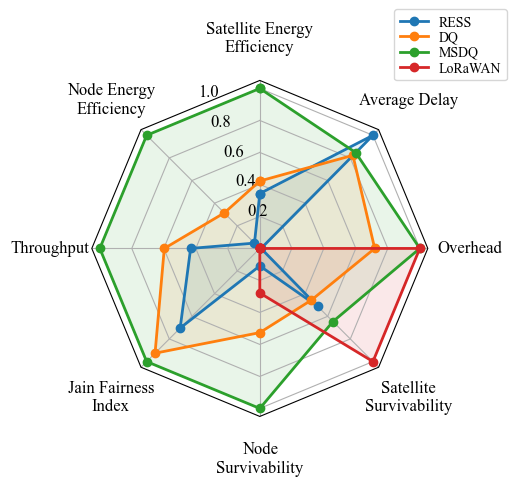

In [15]:
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    theta = np.linspace(0, 2 * np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


plt.rcParams.update({'font.size': 12})
plt.rc('legend', fontsize=12)
plt.rcParams.update({'font.family': 'Times New Roman'})

graph_manager = GraphManager(workspace_name)

metric_names = [
    MetricEngine.SATELLITE_ENERGY_EFFICIENCY,
    MetricEngine.AVG_NODE_ENERGY_EFFICIENCY,
    MetricEngine.THROUGHPUT,
    MetricEngine.JFI,
    MetricEngine.NODE_SURVIVABILITY,
    MetricEngine.SATELLITE_SURVIVABILITY,
    MetricEngine.OVERHEAD,
    MetricEngine.AVERAGE_DELAY,
]

labels = []

data = []
for data_source in data_sources:
    protocol_name = data_source.split("-")[0]
    labels.append(protocol_name)
    protocol_data = []
    for metric in metric_names:
        ys = graph_manager.metric_data[data_source]["5000"][metric]
        y = np.average(ys)

        # Fix for LoRa having no overhead and no delay at 5k nodes because it has 0 kb/hr of throughput
        if metric == MetricEngine.OVERHEAD or metric == MetricEngine.AVERAGE_DELAY:
            y = 1 / y if y > 0 else 0

        protocol_data.append(y)
    data.append(protocol_data)

for i in range(len(data[0])):
    metric_upper_bound = max([protocol_data[i] for protocol_data in data])
    for j in range(len(data)):
        if metric_names[i] == MetricEngine.OVERHEAD and data[j][i] == 0:  # FIX for LoRa having no overhead
            data[j][i] = metric_upper_bound / metric_upper_bound
        else:
            data[j][i] = data[j][i] / metric_upper_bound

theta = radar_factory(len(metric_names), frame='polygon')

fig, ax = plt.subplots(subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.15)
ax.tick_params(pad=20)

colors = ['C0', 'C1', 'C2', 'C3']
ax.set_rgrids([0.2, 0.4, 0.6, 0.8, 1.0])
for d, color in zip(data, colors):
    ax.plot(theta, d, 'o', ls='-', color=color, linewidth=2.0)
    ax.fill(theta, d, facecolor=color, alpha=0.1, label='_nolegend_')

ax.set_varlabels([
    "Satellite Energy\nEfficiency",
    "Node Energy\nEfficiency",
    "Throughput",
    "Jain Fairness\nIndex",
    "Node\nSurvivability",
    "Satellite\nSurvivability",
    "Overhead",
    "Average Delay",
])

# add legend relative to top-left plot
legend = ax.legend(labels, loc=(0.9, 1.0), labelspacing=0.1, fontsize='small')

graph_manager.save_plot("relative_scoring_spider_graph")